In [ ]:
!pip install opencv-python fer matplotlib
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
import cv2
import numpy as np
from fer import FER
import matplotlib.pyplot as plt
from google.colab import files

In [7]:
def non_max_suppression(boxes, overlap_thresh=0.3):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes, dtype="float")
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + x1
    y2 = boxes[:, 3] + y1
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:-1]])
        yy1 = np.maximum(y1[i], y1[idxs[:-1]])
        xx2 = np.minimum(x2[i], x2[idxs[:-1]])
        yy2 = np.minimum(y2[i], y2[idxs[:-1]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:-1]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
    return boxes[pick].astype("int")

In [40]:
#uploaded = files.upload()
image_path = "/content/happy.jpg"
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

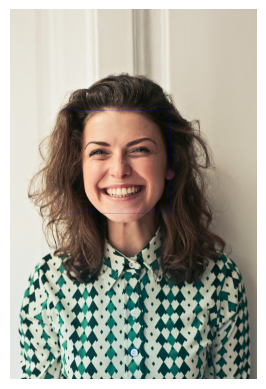

Detected 2 face(s)


In [42]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=15, minSize=(30, 30))

if len(faces) > 0:
    faces = non_max_suppression(faces)

# Draw rectangles around faces
img_with_boxes = img.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
print(f"Detected {len(faces)} face(s)")

In [43]:
detector = FER(mtcnn=True)  # Use MTCNN for better face detection
result = detector.detect_emotions(img)
if result:
    emotions = result[0]['emotions']
    dominant_emotion = max(emotions.items(), key=lambda x: x[1])[0]
    confidence = emotions[dominant_emotion]
    print(f"Dominant Emotion: {dominant_emotion} ({confidence:.2f})")
else:
    dominant_emotion = "neutral"
    confidence = 1.0
    print("No face detected, defaulting to neutral")

Dominant Emotion: happy (0.99)


In [44]:
img_with_filter = img.copy()
for (x, y, w, h) in faces:
    if dominant_emotion == "happy":
        cv2.circle(img_with_filter, (x+w//2, y-20), 20, (0, 255, 0), -1)  # Green circle
    elif dominant_emotion == "sad":
        pts = np.array([[x+w//2, y+h], [x+w//2-10, y+h+20], [x+w//2+10, y+h+20]])
        cv2.fillPoly(img_with_filter, [pts], (255, 0, 0))  # Blue teardrop
    elif dominant_emotion == "angry":
        pts = np.array([[x+w//2, y-30], [x+w//2-20, y-10], [x+w//2+20, y-10]])
        cv2.fillPoly(img_with_filter, [pts], (0, 0, 255))  # Red triangle
    cv2.putText(img_with_filter, dominant_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

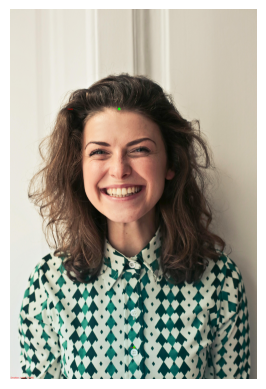

True

In [45]:
text = f"Emotion: {dominant_emotion} ({confidence:.2f})"
cv2.putText(
    img_with_filter,
    text,
    (10, img_with_filter.shape[0] - 10),  # Bottom-left corner
    cv2.FONT_HERSHEY_SIMPLEX,
    1.0,  # Font scale
    (0, 0, 255),  # Red text
    2  # Thickness
)
plt.imshow(cv2.cvtColor(img_with_filter, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
cv2.imwrite('filtered_image.png', img_with_filter)